# Nonlinear Least Squares curve fitting
Trying to put together a minimal implementation of the Levenberg-Marquardt algorithm for nonlinear least squares curve fitting.
This is mostly for my own learning, but it was also requested on [my blog](https://workyourtech.com/2020/04/05/fitting-curves-to-data-with-an-arduino/#comment-28)

## Following these papers: [this](http://people.duke.edu/~hpgavin/ce281/lm.pdf) and [this](https://www.eecs189.org/static/notes/n12.pdf)

# Nomenclature
x - x-values (probably time)
f(x) - function we're modelling the data as, this takes parameters p
y - f(x) data we're fitting the function to
p - parameters

In [1]:
using Plots
using LinearAlgebra # For I

## Chi square measure of goodness of fit (used for λ measure in LM algo)

In [2]:
function chisquare(O, E)
    return sum(((O .- E).^2) ./ E)
end

chisquare (generic function with 1 method)

## Parameter delta helper for Jacobian calculator (Forward differences)
The nicest way I've found to calculate the jacobian matrix is by generating a square matrix with each parameter perturbation in a row like this, then map each row of the perturbation matrix to get mxn matrix

In [16]:
function perturbparameters(parameters, perturbation)
    return parameters .* (ones(length(parameters), length(parameters)) + perturbation * I)
end
perturbparameters([1, 2, 3], 0.001)

3×3 Array{Float64,2}:
 1.001  1.0    1.0
 2.0    2.002  2.0
 3.0    3.0    3.003

3×3 Array{Float64,2}:
 1.001  1.0    1.0
 2.0    2.002  2.0
 3.0    3.0    3.003

## Jacobian function
The functions we're working with here take a vector of datapoints of **m** length and return a vector of the function applied to each of those datapoints.

The function takes **n** parameters.

The jacobian is an **m**x**n** matrix that gives the gradient of each parameter if all the others are fixed, for all **n** datapoints.

In [17]:
function jacobian(f, x::Vector{Float64}, parameters, perturbation=0.0001)::Array{Float64, 2}
    return cat(
        map(row -> (f(x, row...) - f(x, parameters...)) / perturbation,
            eachrow(perturbparameters(parameters, perturbation)))...,
        dims=2)
end

jacobian (generic function with 2 methods)

## Meat of the algo, two different update functions, gradient descent and gauss-newton

In [14]:
loss

UndefVarError: [91mUndefVarError: loss not defined[39m

In [20]:
min(1, 2, 3)

1

In [103]:
function gradient(y, ŷ, J, W=I)
    return transpose(J)*W*(y-ŷ)
end

function gaussnewton(y, ŷ, J, W=I)
    return inv(transpose(J)*W*J)*transpose(J)*W*(y-ŷ)
end

function lm(y, ŷ, J, λ, W=I)
    grad = transpose(J)*W*(y-ŷ)
    second = transpose(J)*W*J + λ*Diagonal(transpose(J)*W*J)
    return  inv(second) * grad
end

# symbol ρᵢ in first paper, this is compared to a user-given measure ϵ
function lmmetric(f, x, y, p, h, λ, J, W=I)
    yold = f(x, p...)
    ynew = f(x, (p .+ h)...)
    return (chisquare(y, yold) - chisquare(y, ynew)) /
        (transpose(h) * (λ * Diagonal(transpose(J)*W*J) * h + transpose(J)*W*(y-yold)))
end

# Todo: Use Broyden rank-1 update for updating jacobian in certain conditions
# http://people.duke.edu/~hpgavin/ce281/lm.pdf
# https://www.eecs189.org/static/notes/n12.pdf

function step(f, x::Vector{Float64}, y::Vector{Float64}, parameters, ϵ=1e-2; loss=(y, ŷ)->(sum((y-ŷ).^2)))
    p = copy(parameters)
    
    λfactordown = 9
    λfactorup = 11
    λ = 1e-2
    
    iterations = 1
    while true
        ŷ = f(x, p...)
        J = jacobian(f, x, parameters)
        
        h = lm(y, ŷ, J, λ)
        ρ =lmmetric(f, x, y, parameters, h, λ, J)
        
        if ρ > ϵ
            p = p + h
            λ = max(λ / λfactordown, 10^7)
        else
            λ = min(λ * λfactorup, 10^7)
        end

        
        sumsquares = loss(y, ŷ)
        println("Experiment new parameters $(p) loss: $(sumsquares)")
        sumsquares > 1 || break
        iterations = iterations + 1
        iterations > 50 && break
    end
    return p
end

step (generic function with 2 methods)

In [104]:
α = 0.01
f(x, a, b, c, d, e) = a.+b.*exp.(-c.*x) .* sin.(d.*x.+e)
x = collect(0:0.1:3)
y = f(x, 5, 6, 7, 8, 9)
p = [1, 1, 1, 1, 1]

5-element Array{Int64,1}:
 1
 1
 1
 1
 1

Experiment new parameters [4.038690106598693, 1.7658279188291317, 2.299034303500676, -3.4260640373760847, 1.2302353205116248] loss: 444.6852156779073
Experiment new parameters [4.038690194553941, 1.7658280307888727, 2.299034023075169, -3.4260644748660742, 1.2302350700891729] loss: 34.26140894252938
Experiment new parameters [4.038690282509185, 1.7658281427486238, 2.2990337426496614, -3.426064912356015, 1.2302348196667634] loss: 34.26140547003026
Experiment new parameters [4.038690370464424, 1.765828254708385, 2.2990334622241524, -3.426065349845907, 1.2302345692443961] loss: 34.261401997531365
Experiment new parameters [4.03869045841966, 1.7658283666681565, 2.299033181798642, -3.42606578733575, 1.2302343188220712] loss: 34.2613985250327
Experiment new parameters [4.038690546374893, 1.765828478627938, 2.2990329013731308, -3.426066224825544, 1.2302340683997885] loss: 34.26139505253424
Experiment new parameters [4.038690634330121, 1.7658285905877296, 2.299032620947618, -3.4260666623152893,

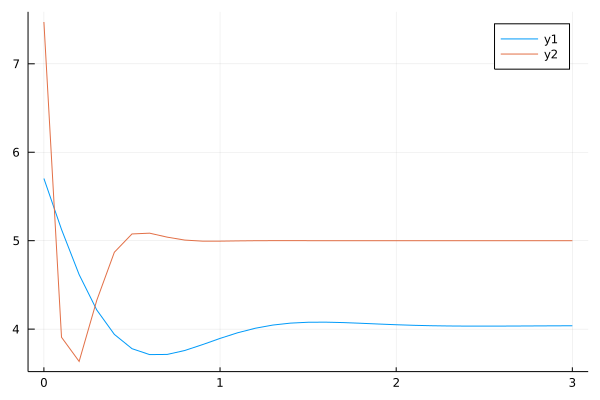

In [105]:
newparameters = step(f, collect(x), y, p)
ŷ = f(x, newparameters...)
plot([x, x], [ŷ, y])

In [96]:
chisquare(y, ŷ)

383.6712276372895

In [97]:
print(newparameters)

UndefVarError: [91mUndefVarError: newparameters not defined[39m